In [198]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [199]:
def load_photos(root_dir):
    images = {}
    # Iterate through subdirectories
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.tif'):
                if 'mask' in filename:
                    filename = filename.replace('_mask.tif', '')
                    if filename not in images:
                        images[filename] = {}
                    img = cv2.imread(os.path.join(dirpath, filename + '_mask.tif'))
                    images[filename]['mask'] = img
                else:
                    filename = filename.replace('.tif', '')
                    if filename not in images:
                        images[filename] = {}
                    img = cv2.imread(os.path.join(dirpath, filename + '.tif'))
                    images[filename]['image'] = img
        

    return images

root_directory = './data/dataset/'
images = load_photos(root_directory)

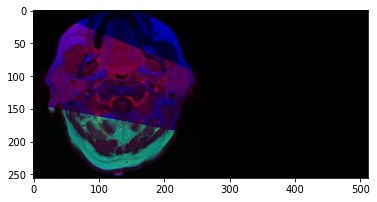

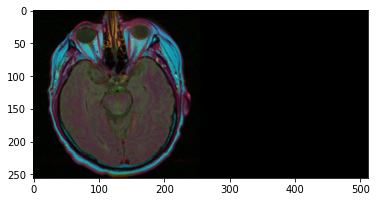

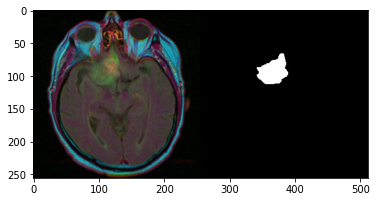

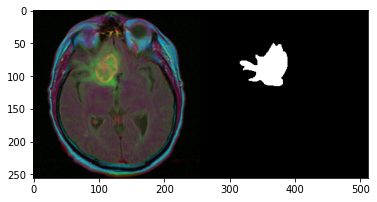

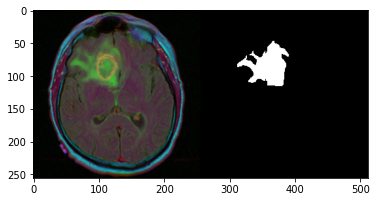

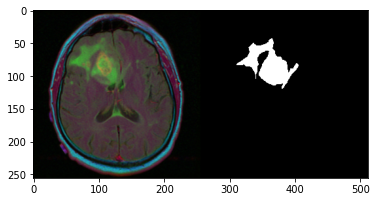

In [200]:
for i, image in enumerate(images.values()):
    plt.imshow(np.concatenate([image['image'], image['mask']], axis=1))
    plt.show()
    if i == 5:
        break

In [201]:
class ImageAugmentor:
    def __init__(self, prob) -> None:
        self.prob = prob

    def flip(self, image, mask):
        if np.random.rand() < self.prob:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)
        return image, mask
    
    def rotate(self, image, mask):
        if np.random.rand() < self.prob:
            angle = np.random.randint(-10, 11) # tilt only by small amounts
            height, width = image.shape[:2]

            tilt_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

            image = cv2.warpAffine(image, tilt_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)
            mask = cv2.warpAffine(mask, tilt_matrix, (width, height), borderMode=cv2.BORDER_REFLECT)

        return image, mask
    
    def change_brightness(self, image, mask):
        if np.random.rand() < self.prob:
            factor = np.random.uniform(0.7, 1.3)
            image = image * factor
            image = np.clip(image, 0, 255)
            image = image.astype(np.uint8)
        return image, mask
    
    def augment(self, image, mask):
        image, mask = self.flip(image, mask)
        image, mask = self.rotate(image, mask)
        image, mask = self.change_brightness(image, mask)
        return image, mask
    
    

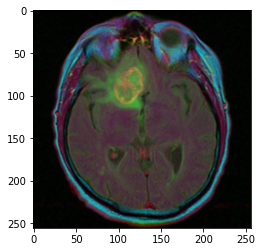

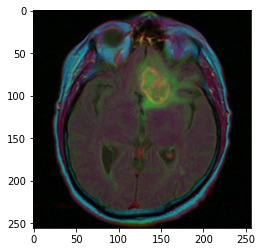

In [202]:
image = cv2.imread('./kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif')
plt.imshow(image)
plt.show()
augmentor = ImageAugmentor(1)
image = augmentor.augment(image, image)[0]
plt.imshow(image)
plt.show()

In [203]:
augmentor = ImageAugmentor(0.8)

In [204]:
X,y = [], []
starting_num = len(images)
ending_num = 10_000

In [205]:
for i, image in enumerate(images.values()):
    X.append(image['image'])
    y.append(image['mask'])
    image, mask = augmentor.augment(image['image'], image['mask'])
    X.append(image)
    y.append(mask)

In [206]:
while len(X) < ending_num:
    i = np.random.randint(0, starting_num)
    image = X[i]
    mask = y[i]
    image, mask = augmentor.augment(image, mask)
    X.append(image)
    y.append(mask)

In [207]:
indices = np.random.permutation(len(X))
X = np.array(X)[indices]
y = np.array(y)[indices]

In [208]:
X_train = X[:int(ending_num*0.6)]
y_train = y[:int(ending_num*0.6)]

X_val = X[int(ending_num*0.6):int(ending_num*0.8)]
y_val = y[int(ending_num*0.6):int(ending_num*0.8)]

X_test = X[int(ending_num*0.8):]
y_test = y[int(ending_num*0.8):]


In [209]:
print(len(X_train), len(X_val), len(X_test))
print(len(y_train), len(y_val), len(y_test))

6000 2000 2000
6000 2000 2000


In [210]:
output_dir = "data/img"
os.makedirs(output_dir, exist_ok=True)
X = [X_train, X_val, X_test]
names = ["train", "val", "test"]
for x, name in zip(X, names):
    for idx, img in enumerate(x):
        output_file_path = f"{output_dir}/{name}/image{idx + 1}.tif"
        cv2.imwrite(output_file_path, img)

In [211]:
output_dir = "data/mask"
os.makedirs(output_dir, exist_ok=True)
y = [y_train, y_val, y_test]
names = ["train", "val", "test"]
for y_, name in zip(y, names):
    for idx, img in enumerate(y_):
        output_file_path = f"{output_dir}/{name}/image{idx + 1}_mask.tif"
        cv2.imwrite(output_file_path, img)

In [218]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np

In [219]:
class MriDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = f'{self.image_dir}/{self.images[index]}'
        mask_path = f'{self.mask_dir}/{self.images[index].replace(".tif", "_mask.tif")}'

        image = np.array(Image.open(img_path).convert("RGB")).transpose((2, 0, 1))
        mask = np.array(Image.open(mask_path).convert('L'), dtype=np.float32)
        mask[mask >= 1.] = 1.0
        
        return image, mask

In [220]:
def get_loaders(train_dir, train_maskdir, val_dir, val_maskdir, batch_size, num_workers=0, pin_memory=True):
    train_ds = MriDataset(train_dir, train_maskdir)
    train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=True)
    val_ds = MriDataset(val_dir, val_maskdir)
    val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, shuffle=False)

    return train_loader, val_loader